In [ ]:
! pip install -q -U neuralgcm dinosaur gcsfs cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.0/175.0 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.8/201.8 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 130.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.3/374.3 kB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.8/87.8 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.8/306.8 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.1/284.1 kB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 130.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 4.0.0 requires fsspe

In [ ]:
import jax
import jax.numpy as jnp
from jax import lax, tree_util as jtu, grad, jit, checkpoint, value_and_grad, block_until_ready
import optax
import numpy as np
import pickle
import xarray
from functools import partial
import gcsfs
from tqdm import tqdm
import sys
import os
import yaml
import matplotlib.pyplot as plt
import argparse

from dinosaur import (horizontal_interpolation,
                     spherical_harmonic,
                     xarray_utils)
import neuralgcm


gcs = gcsfs.GCSFileSystem(token='anon')



In [ ]:
config ={"lat_min": 46.0,
"lat_max": 51.,
"lon_min": -120.5,
"lon_max": -125.00,
"learning_rate":1e-9,
"epochs":25,
"lambda":50,
"beta":1
}


In [ ]:
# Load model
model_name = 'v1/deterministic_1_4_deg.pkl' #'v1/deterministic_2_8_deg.pkl'
with gcs.open(f'gs://neuralgcm/models/{model_name}', 'rb') as f:
    ckpt = pickle.load(f)


model = neuralgcm.PressureLevelModel.from_checkpoint(ckpt)

In [ ]:
# Load initial data
era5_path = 'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3'
full_era5 = xarray.open_zarr(
    era5_path, chunks=None, storage_options=dict(token='anon')
)

demo_start_time = '2008-11-11T00:00'
demo_end_time = '2008-11-11T01:00'
data_inner_steps = 24

sliced_era5 = (
    full_era5
    [model.input_variables + model.forcing_variables]
    .pipe(
        xarray_utils.selective_temporal_shift,
        variables=model.forcing_variables,
        time_shift='24 hours',
    )
    .sel(time=slice(demo_start_time, demo_end_time, data_inner_steps))
    .compute()
)

era5_grid = spherical_harmonic.Grid(
    latitude_nodes=sliced_era5.sizes['latitude'],
    longitude_nodes=sliced_era5.sizes['longitude'],
    latitude_spacing=xarray_utils.infer_latitude_spacing(sliced_era5.latitude),
    longitude_offset=xarray_utils.infer_longitude_offset(sliced_era5.longitude),
)

regridder = horizontal_interpolation.ConservativeRegridder(
    era5_grid, model.data_coords.horizontal, skipna=True
)
eval_era5 = xarray_utils.regrid(sliced_era5, regridder)
eval_era5 = xarray_utils.fill_nan_with_nearest(eval_era5)

# initialize model state
inputs = model.inputs_from_xarray(eval_era5.isel(time=0))
input_forcings = model.forcings_from_xarray(eval_era5.isel(time=0))
rng_key = jax.random.key(42)  #
initial_state = model.encode(inputs, input_forcings, rng_key)

# use persistence for forcing variables (SST and sea ice cover)
all_forcings = model.forcings_from_xarray(eval_era5.head(time=1))

In [ ]:
# Extract and reconstruct differentiable parts of the state
def extract_non_diff(state):
    randomness = state.randomness
    inner_state = state.state
    components = (
        randomness,
        inner_state.sim_time,
        state.memory
    )
    new_inner_state = inner_state.replace(
        sim_time=None
    )
    return state.replace(state=new_inner_state, randomness=None, memory=None), components


def reconstruct_full_state(state_without_non_diff, non_diff_components):
    """Reconstruct the full state by adding back non-differentiable components."""
    randomness, sim_time, memory = non_diff_components
    sim_time = jax.lax.stop_gradient(sim_time)
    inner_state = state_without_non_diff.state
    new_inner_state = inner_state.replace(sim_time=sim_time)
    return state_without_non_diff.replace(randomness=randomness, state=new_inner_state, memory=memory)

In [ ]:
def extract_box_indices(config, grid):
    """
    Input coordinate box from config file and return indices.
    Uses 180°W-180°E convention for input, converts to ERA5's 0-360°E convention.
    """
    # Target domain - input in 180°W-180°E convention
    lat_min = float(config['lat_min'])
    lat_max = float(config['lat_max'])
    lon_min_180 = float(config['lon_min'])
    lon_max_180 = float(config['lon_max'])

    # Convert to ERA5's 0-360°E convention
    lon_min_360 = (lon_min_180) % 360
    lon_max_360 = (lon_max_180) % 360
    print(grid)
    # Find the indices for the latitude range
    lat_indices = np.where((grid[0] >= lat_min) & (grid[0] <= lat_max))[0]

    # Find the indices for the longitude range
    lon_indices = np.where((grid[1] <= lon_min_360) & (grid[1] >= lon_max_360))[0]

    # Print detailed information matching the region function format
    print(f"Input box (180° conv): lat=[{lat_min:.2f}, {lat_max:.2f}], lon=[{lon_min_180:.2f}, {lon_max_180:.2f}]")
    print(f"ERA5 box (360° conv): lat=[{lat_min:.2f}, {lat_max:.2f}], lon=[{lon_min_360:.2f}, {lon_max_360:.2f}]")
    print(f"Selected latitude values: {grid[0][lat_indices]}")
    print(f"Selected longitude values: {grid[1][lon_indices]}")
    print(f"Latitude indices: {list(lat_indices)}")
    print(f"Longitude indices: {list(lon_indices)}")
    print(f"Box boundaries: lat=[{grid[0][min(lat_indices)]:.2f}, {grid[0][max(lat_indices)]:.2f}], "
          f"lon=[{grid[1][min(lon_indices)]:.2f}, {grid[1][max(lon_indices)]:.2f}]")

    lat_idx_arr = np.asarray(lat_indices, dtype=np.int32)
    lon_idx_arr = np.asarray(lon_indices, dtype=np.int32)
    return lat_idx_arr, lon_idx_arr



# extract area:
mask = extract_box_indices(
    config = config,
    grid = [eval_era5.latitude.values, eval_era5.longitude.values]
)


outer_steps = 3*24  # Total trajectory steps per iteration

[array([-88.92773535, -87.53870521, -86.1414721 , -84.74238559,
       -83.34259604, -81.9424663 , -80.54214643, -79.14170965,
       -77.74119587, -76.3406287 , -74.94002302, -73.53938863,
       -72.13873229, -70.73805877, -69.33737157, -67.9366733 ,
       -66.53596594, -65.13525103, -63.73452977, -62.33380314,
       -60.93307192, -59.53233673, -58.13159812, -56.7308565 ,
       -55.33011226, -53.9293657 , -52.52861709, -51.12786664,
       -49.72711456, -48.32636102, -46.92560615, -45.5248501 ,
       -44.12409297, -42.72333486, -41.32257587, -39.92181607,
       -38.52105553, -37.12029431, -35.71953248, -34.31877008,
       -32.91800716, -31.51724377, -30.11647993, -28.7157157 ,
       -27.3149511 , -25.91418615, -24.5134209 , -23.11265536,
       -21.71188955, -20.31112351, -18.91035725, -17.50959079,
       -16.10882416, -14.70805736, -13.30729041, -11.90652333,
       -10.50575615,  -9.10498886,  -7.70422148,  -6.30345404,
        -4.90268653,  -3.50191898,  -2.1011514 ,  -0.7

In [ ]:
def compute_references(initial_diff_state):
    """Compute all your “<something>_ref” scalars from the initial state."""
    s = initial_diff_state.state
    return {
        "p_ref": jnp.mean(s.log_surface_pressure) ** 2,
        "d_ref": jnp.mean(s.divergence) ** 2,
        "v_ref": jnp.mean(s.vorticity) ** 2,
        "IVT_ref": 1200,  # constant
        "T0_ref": jnp.mean(s.temperature_variation) ** 2,
        "sh_ref": jnp.mean(s.tracers["specific_humidity"]) ** 2,
        "sciwc_ref": jnp.mean(s.tracers["specific_cloud_ice_water_content"]) ** 2,
        "sclwc_ref": jnp.mean(s.tracers["specific_cloud_liquid_water_content"]) ** 2,
    }

def reg_term(diff, ref, weight):
    """One weighted MSE term."""
    return weight * jnp.mean((diff - ref) ** 2)

def aggregate_regs(diff_state, initial_diff_state, refs):
    """Compute the sum of all seven regularizers, each scaled by 1/ref."""
    s0 = diff_state.state
    s1 = initial_diff_state.state
    regs = [
        reg_term(s0.log_surface_pressure, s1.log_surface_pressure, 10.0) / refs["p_ref"],
        reg_term(s0.divergence,              s1.divergence,              10.0) / refs["d_ref"],
        reg_term(s0.vorticity,               s1.vorticity,               10.0) / refs["v_ref"],
        reg_term(s0.temperature_variation,   s1.temperature_variation,   10.0) / refs["T0_ref"],
        reg_term(s0.tracers["specific_humidity"],
                 s1.tracers["specific_humidity"], 10.0) / refs["sh_ref"],
        reg_term(s0.tracers["specific_cloud_ice_water_content"],
                 s1.tracers["specific_cloud_ice_water_content"], 10.0) / refs["sciwc_ref"],
        reg_term(s0.tracers["specific_cloud_liquid_water_content"],
                 s1.tracers["specific_cloud_liquid_water_content"], 10.0) / refs["sclwc_ref"],
    ]
    return sum(regs)


def compute_ivt(q, u, v, pressure_levels, days, mask):
    """
    Compute Integrated Vapor Transport (IVT).

    Args:
        q: [time, batch, lev, lat, lon] - specific humidity (assuming batch size 1)
        u: [time, batch, lev, lat, lon] - u-component of wind (assuming batch size 1)
        v: [time, batch, lev, lat, lon] - v-component of wind (assuming batch size 1)
        pressure_levels: pressure levels in hPa

    Returns:
        ivt: [lat, lon] - integrated vapor transport magnitude
    """
    g = 9.80665
    p = jnp.array(pressure_levels) * 100.0  # Convert to Pa

    q = q[:,0,:,:,:]
    u = u[:,0,:,:,:]
    v = v[:,0,:,:,:]


    # Compute dp using trapezoidal rule over levels
    dp = jnp.zeros_like(p)
    dp = dp.at[1:-1].set((p[:-2] - p[2:]) / 2.0)    # central difference
    dp = dp.at[0].set(p[0] - p[1])                 # forward diff at top
    dp = dp.at[-1].set(p[-2] - p[-1])              # backward diff at surface
    dp = dp[None, :, None, None]  # Add dimensions for broadcasting

    # Integrate IVT components
    ivt_u = jnp.sum(q * u * dp, axis=1) / g
    ivt_v = jnp.sum(q * v * dp, axis=1) / g

    ivt_magnitude_time_lat_lon = jnp.sqrt(ivt_u**2 + ivt_v**2)


    # Perform the spatial mean using the original slicing from the loss function
    original_spatial_mean_slice = ivt_magnitude_time_lat_lon[24+6:24*2+6, mask[1][0]:mask[1][-1], mask[0][0]:mask[0][-1]] # Added +1 to include the last index


    return jnp.mean(original_spatial_mean_slice) # Return the mean of the original slice


def assemble_loss(beta, lam, refs, final_temp, reg_sum):
    """Combine everything into your final scalar loss."""
    return (refs["IVT_ref"] - jnp.mean(final_temp))**2 + lam * reg_sum

In [ ]:
#@partial(jax.jit)
def compute_loss(diff_state, non_diff_components, initial_diff_state):
    # 1) reconstruct
    full_state = reconstruct_full_state(diff_state, non_diff_components)

    # 2) checkpointed rollout
    def scan_fn(carry, _):
        st, preds = model.unroll(
            carry, all_forcings, steps=1, start_with_input=True
        )
        return st, preds

    _, trajs = lax.scan(
        jax.checkpoint(scan_fn),
        full_state,
        None,
        length=outer_steps
    )

    # 3) pull hyperparams
    beta = float(config["beta"])
    lam  = float(config["lambda"])
    days = 1 #config["loss"].get("final_temp_days", 5)

    q_traj = trajs["specific_humidity"]
    # Get pressures
    pressure_levels = model.data_coords.vertical.centers
    p = jnp.array(pressure_levels) * 100.0 # convert to Pa
    u = trajs['u_component_of_wind']       # shape: [time, lev, lat, lon]
    v = trajs['v_component_of_wind']

    # 4) compute each chunk via loss_functions
    refs  = compute_references(initial_diff_state)

    max_ivt = compute_ivt(q_traj, u, v, pressure_levels, days, mask)
    regsum  = aggregate_regs(diff_state, initial_diff_state, refs)


    # 5) assemble
    loss = assemble_loss(beta, lam, refs, max_ivt, regsum)
    return loss, max_ivt

@partial(jax.jit)
@jax.checkpoint # Added checkpointing to the update_step
def update_step(diff_state, opt_state, non_diff_components, initial_diff_state):
    """Single optimization step preserving non-diff components"""

    (loss, IVT), grads = jax.value_and_grad(compute_loss,has_aux=True)(diff_state, non_diff_components, initial_diff_state)

    # Apply updates
    updates, opt_state = optimizer.update(grads, opt_state)
    diff_state = optax.apply_updates(diff_state, updates)

    return diff_state, opt_state, loss, IVT

# Initialization
initial_diff_state, initial_non_diff = extract_non_diff(initial_state)
optimizer = optax.adam(learning_rate=float(config['learning_rate']))
opt_state = optimizer.init(initial_diff_state)
# Training loop
current_diff = initial_diff_state
current_non_diff = initial_non_diff

times = np.arange(outer_steps)
losses = []

In [ ]:
# Initialization
initial_diff_state, initial_non_diff = extract_non_diff(initial_state)
optimizer = optax.adam(learning_rate=1e-10)
opt_state = optimizer.init(initial_diff_state)
# Training loop
current_diff = initial_diff_state
current_non_diff = initial_non_diff

times = np.arange(outer_steps)
losses = []
training_ivt_values = [] # List to store IVT values from training
final_training_ivt = None # Variable to store the final IVT value from training

pbar = tqdm(range(150), desc="Optimizing")
for step in pbar:
    current_diff, opt_state, loss, temp = update_step(
        current_diff,
        opt_state,
        current_non_diff,
        initial_diff_state
    )
    losses.append(loss)
    training_ivt_values.append(temp) # Store the IVT value from this epoch
    final_training_ivt = temp # Update with the latest IVT value
    # Maintain non-diff components across steps
    full_state = reconstruct_full_state(current_diff, current_non_diff)
    _, current_non_diff = extract_non_diff(full_state)

    pbar.set_description(f"Loss: {loss:.4f}, Mean IVT: {temp:.4f}")

print("Training complete.")

Loss: 68031.1172, Mean IVT: 940.8224: 100%|██████████| 150/150 [2:05:39<00:00, 50.27s/it]

Training complete.


In [ ]:
optimized_state = reconstruct_full_state(current_diff, current_non_diff)
final_state, predictions = model.unroll(
    optimized_state,
    all_forcings,
    steps=outer_steps,
    start_with_input=True,
)
predictions_ds = model.data_to_xarray(predictions, times=times)

In [ ]:
predictions_ds.to_netcdf("pred_opt.nc")

In [ ]:
final_state, predictions = model.unroll(
        initial_state,
        all_forcings,
        steps=outer_steps,
        start_with_input=True,
    )
predictions_ds_ori = model.data_to_xarray(predictions, times=times)

In [ ]:
predictions_ds_ori.to_netcdf("pred_ori.nc")

In [ ]:
def compute_ivt_time_series(q_data, u_data, v_data, pressure_levels, mask):
    """
    Compute Integrated Vapor Transport (IVT) time series over a masked spatial region.

    Args:
        q_data: [time, lev, lat, lon] - specific humidity time series
        u_data: [time, lev, lat, lon] - u-component of wind time series
        v_data: [time, lev, lat, lon] - v-component of wind time series
        pressure_levels: pressure levels in hPa
        mask: The latitude and longitude indices defining the target domain.

    Returns:
        ivt_time_series: [time] - mean integrated vapor transport magnitude over the masked region for each time step
    """
    # Convert input xarray DataArrays to JAX arrays
    q_data_jax = jnp.array(q_data.values)
    u_data_jax = jnp.array(u_data.values)
    v_data_jax = jnp.array(v_data.values)
    pressure_levels_jax = jnp.array(pressure_levels) * 100.0  # Convert to Pa and JAX array


    g = 9.80665
    p = pressure_levels_jax # Use the JAX array version


    # Compute dp using trapezoidal rule over levels
    dp = jnp.zeros_like(p)
    dp = dp.at[1:-1].set((p[:-2] - p[2:]) / 2.0)    # central difference
    dp = dp.at[0].set(p[0] - p[1])                 # forward diff at top
    dp = dp.at[-1].set(p[-2] - p[-1])              # backward diff at surface
    dp = dp[None, :, None, None]  # Add dimensions for broadcasting for [time, lev, lat, lon]

    # Integrate IVT components over pressure levels for all time steps

    ivt_u_time_lev = jnp.sum(q_data_jax * u_data_jax * dp, axis=1) / g  # sum over level axis (axis=2)
    ivt_v_time_lev = jnp.sum(q_data_jax * v_data_jax * dp, axis=1) / g

    # Calculate IVT magnitude
    ivt_magnitude_time_lat_lon = jnp.sqrt(ivt_u_time_lev**2 + ivt_v_time_lev**2)

    # Extract the masked spatial region and compute the mean over latitude and longitude
    # Need to handle the case where mask indices might be out of bounds for the sliced data
    lat_indices = mask[1]
    lon_indices = mask[0]

    # Ensure indices are within bounds - though xarray slicing should handle this if mask is correct
    # For robustness with raw JAX slicing, one might add bounds checking, but relying on mask correctness here.

    masked_ivt_time_lat_lon = ivt_magnitude_time_lat_lat = ivt_magnitude_time_lat_lon[:, lat_indices[:, None], lon_indices]
    masked_ivt_time_lat_lon = ivt_magnitude_time_lat_lat = ivt_magnitude_time_lat_lon[:, lat_indices[0]:lat_indices[-1], lon_indices[0]:lon_indices[-1]]
    # Compute the mean over the masked spatial region for each time step
    ivt_time_series = jnp.mean(masked_ivt_time_lat_lon, axis=(-2, -1)) # Mean over the last two dimensions (lat and lon)


    return ivt_time_series

/tmp/ipython-input-1927220147.py:26: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  prediction_times = pd.date_range(start=start_time, periods=outer_steps, freq='H')


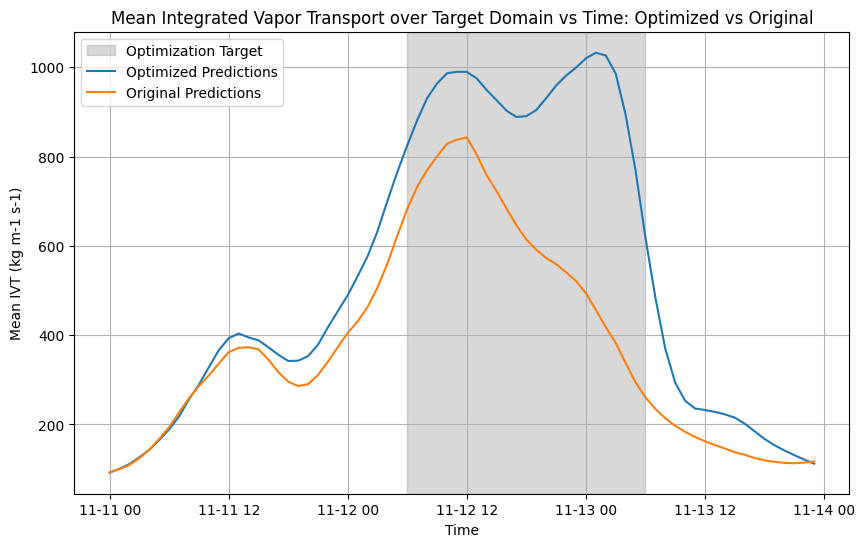

941.99084


In [ ]:
import pandas as pd # Import pandas for date_range

pressure_levels = model.data_coords.vertical.centers

# Use the newly defined function to compute IVT time series
optimized_ivt_time_series = compute_ivt_time_series(
    predictions_ds.specific_humidity,
    predictions_ds.u_component_of_wind,
    predictions_ds.v_component_of_wind,
    pressure_levels,
    mask
)

original_ivt_time_series = compute_ivt_time_series(
    predictions_ds_ori.specific_humidity,
    predictions_ds_ori.u_component_of_wind,
    predictions_ds_ori.v_component_of_wind,
    pressure_levels,
    mask
)

# Get the start time from the demo_start_time string
start_time = pd.to_datetime(demo_start_time)
# Generate hourly time points for the duration of outer_steps
prediction_times = pd.date_range(start=start_time, periods=outer_steps, freq='H')


# Plot the mean IVT vs time for both datasets
plt.figure(figsize=(10, 6))

# Calculate the start and end time for the shaded region based on the index
shaded_start_index = 24 + 6
shaded_end_index = 24 * 2 + 6
shaded_start_time = prediction_times[shaded_start_index]
shaded_end_time = prediction_times[shaded_end_index]
plt.axvspan(shaded_start_time, shaded_end_time, color='gray', alpha=0.3, label='Optimization Target')

# Now plot the time series lines
plt.plot(prediction_times, optimized_ivt_time_series, label='Optimized Predictions')
plt.plot(prediction_times, original_ivt_time_series, label='Original Predictions')


plt.xlabel("Time")
plt.ylabel("Mean IVT (kg m-1 s-1)")
plt.title("Mean Integrated Vapor Transport over Target Domain vs Time: Optimized vs Original")
plt.legend()
plt.grid(True)


plt.show()

print(np.mean(optimized_ivt_time_series[24 + 6:24 * 2 + 6]))

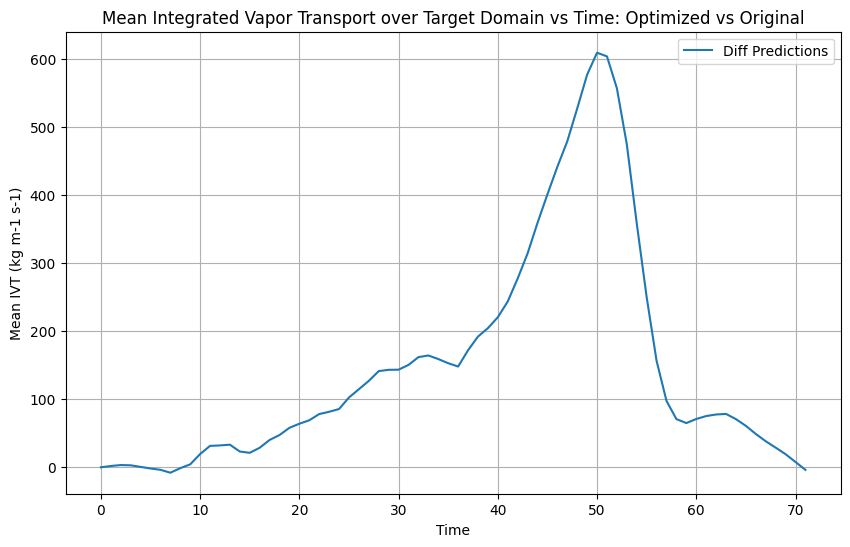

In [ ]:
# Plot the mean IVT vs time for both datasets
plt.figure(figsize=(10, 6))
# Use the generated prediction_times for the x-axis
plt.plot(optimized_ivt_time_series - original_ivt_time_series, label='Diff Predictions')
plt.xlabel("Time")
plt.ylabel("Mean IVT (kg m-1 s-1)")
plt.title("Mean Integrated Vapor Transport over Target Domain vs Time: Optimized vs Original")
plt.legend()
plt.grid(True)
plt.show()

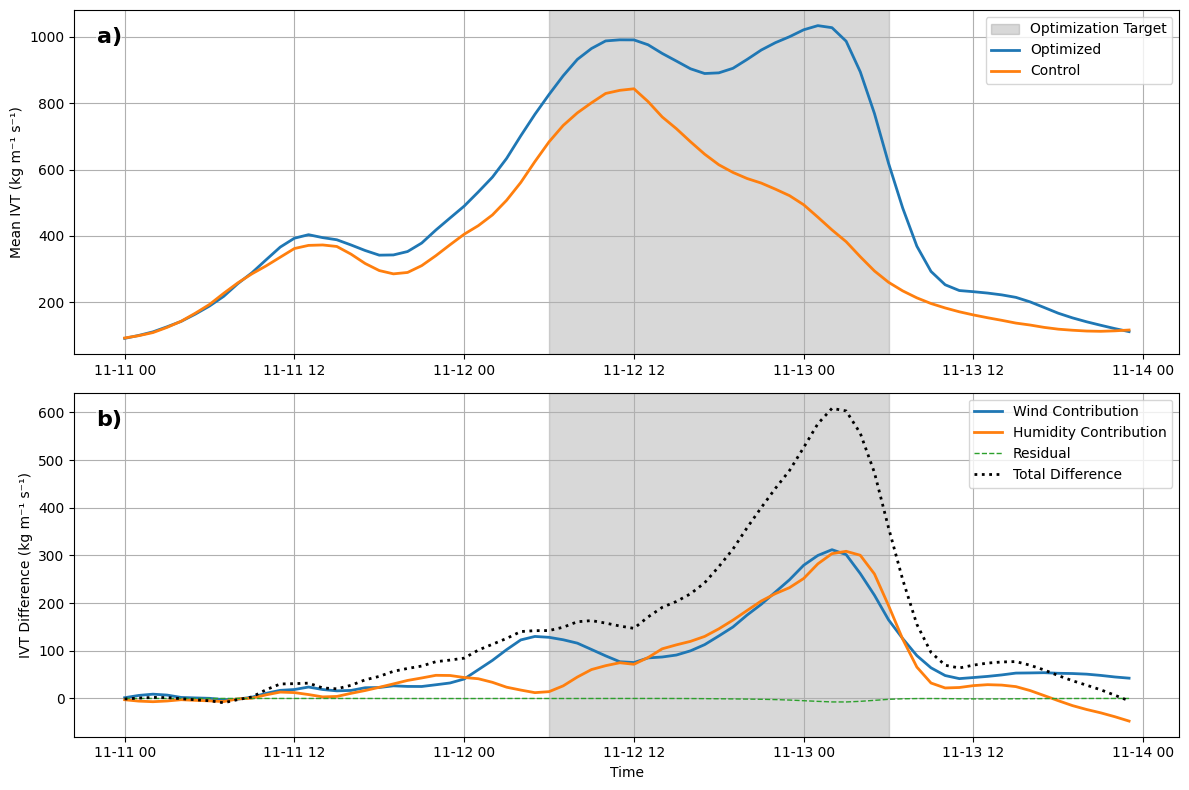

TIME-AVERAGED DECOMPOSITION:
Total IVT difference: 146.863 kg m⁻¹ s⁻¹
Wind contribution: 83.062 kg m⁻¹ s⁻¹ (56.6%)
Humidity contribution: 64.586 kg m⁻¹ s⁻¹ (44.0%)
Residual: -0.785 kg m⁻¹ s⁻¹ (-0.5%)
Generating Figure 2: Control and Optimized IVT over North America...


/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_1_states_provinces_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


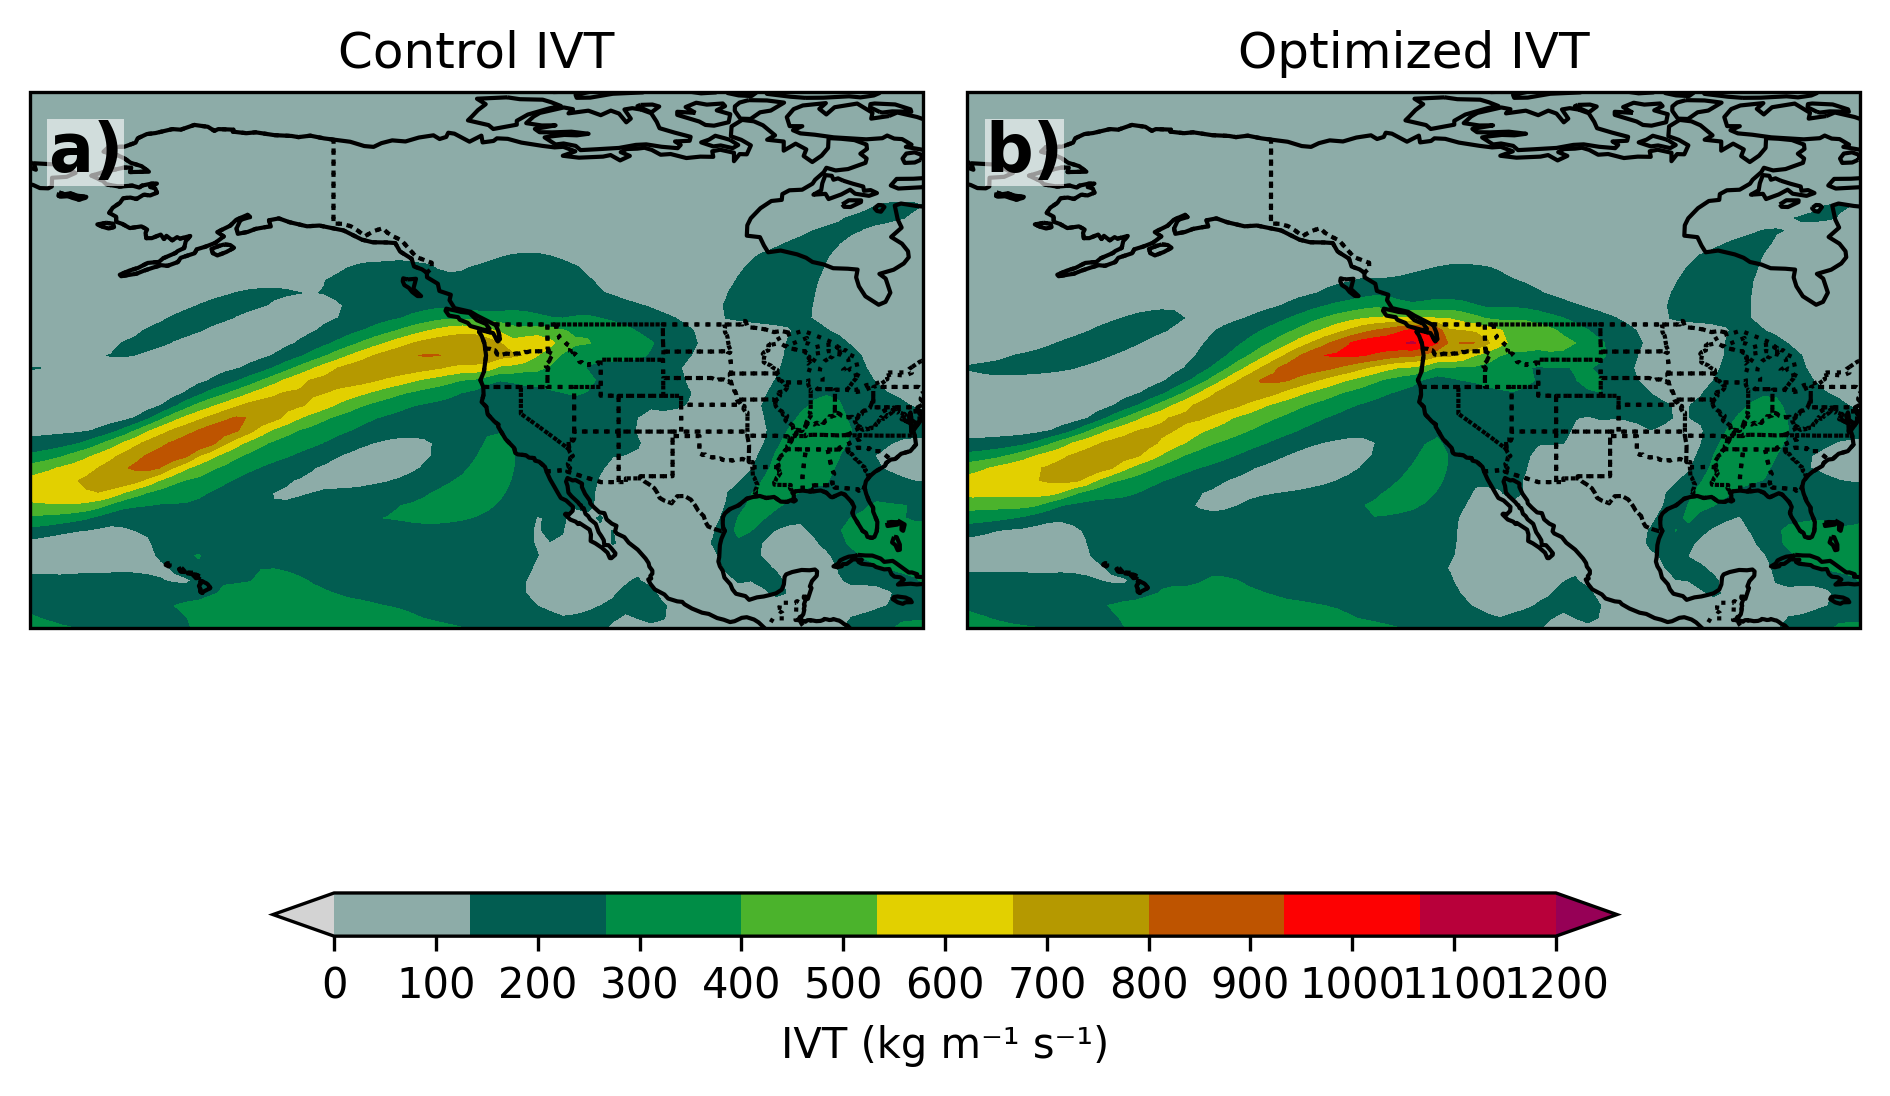

Generating Figure 3: IVT Difference Decomposition over North America...


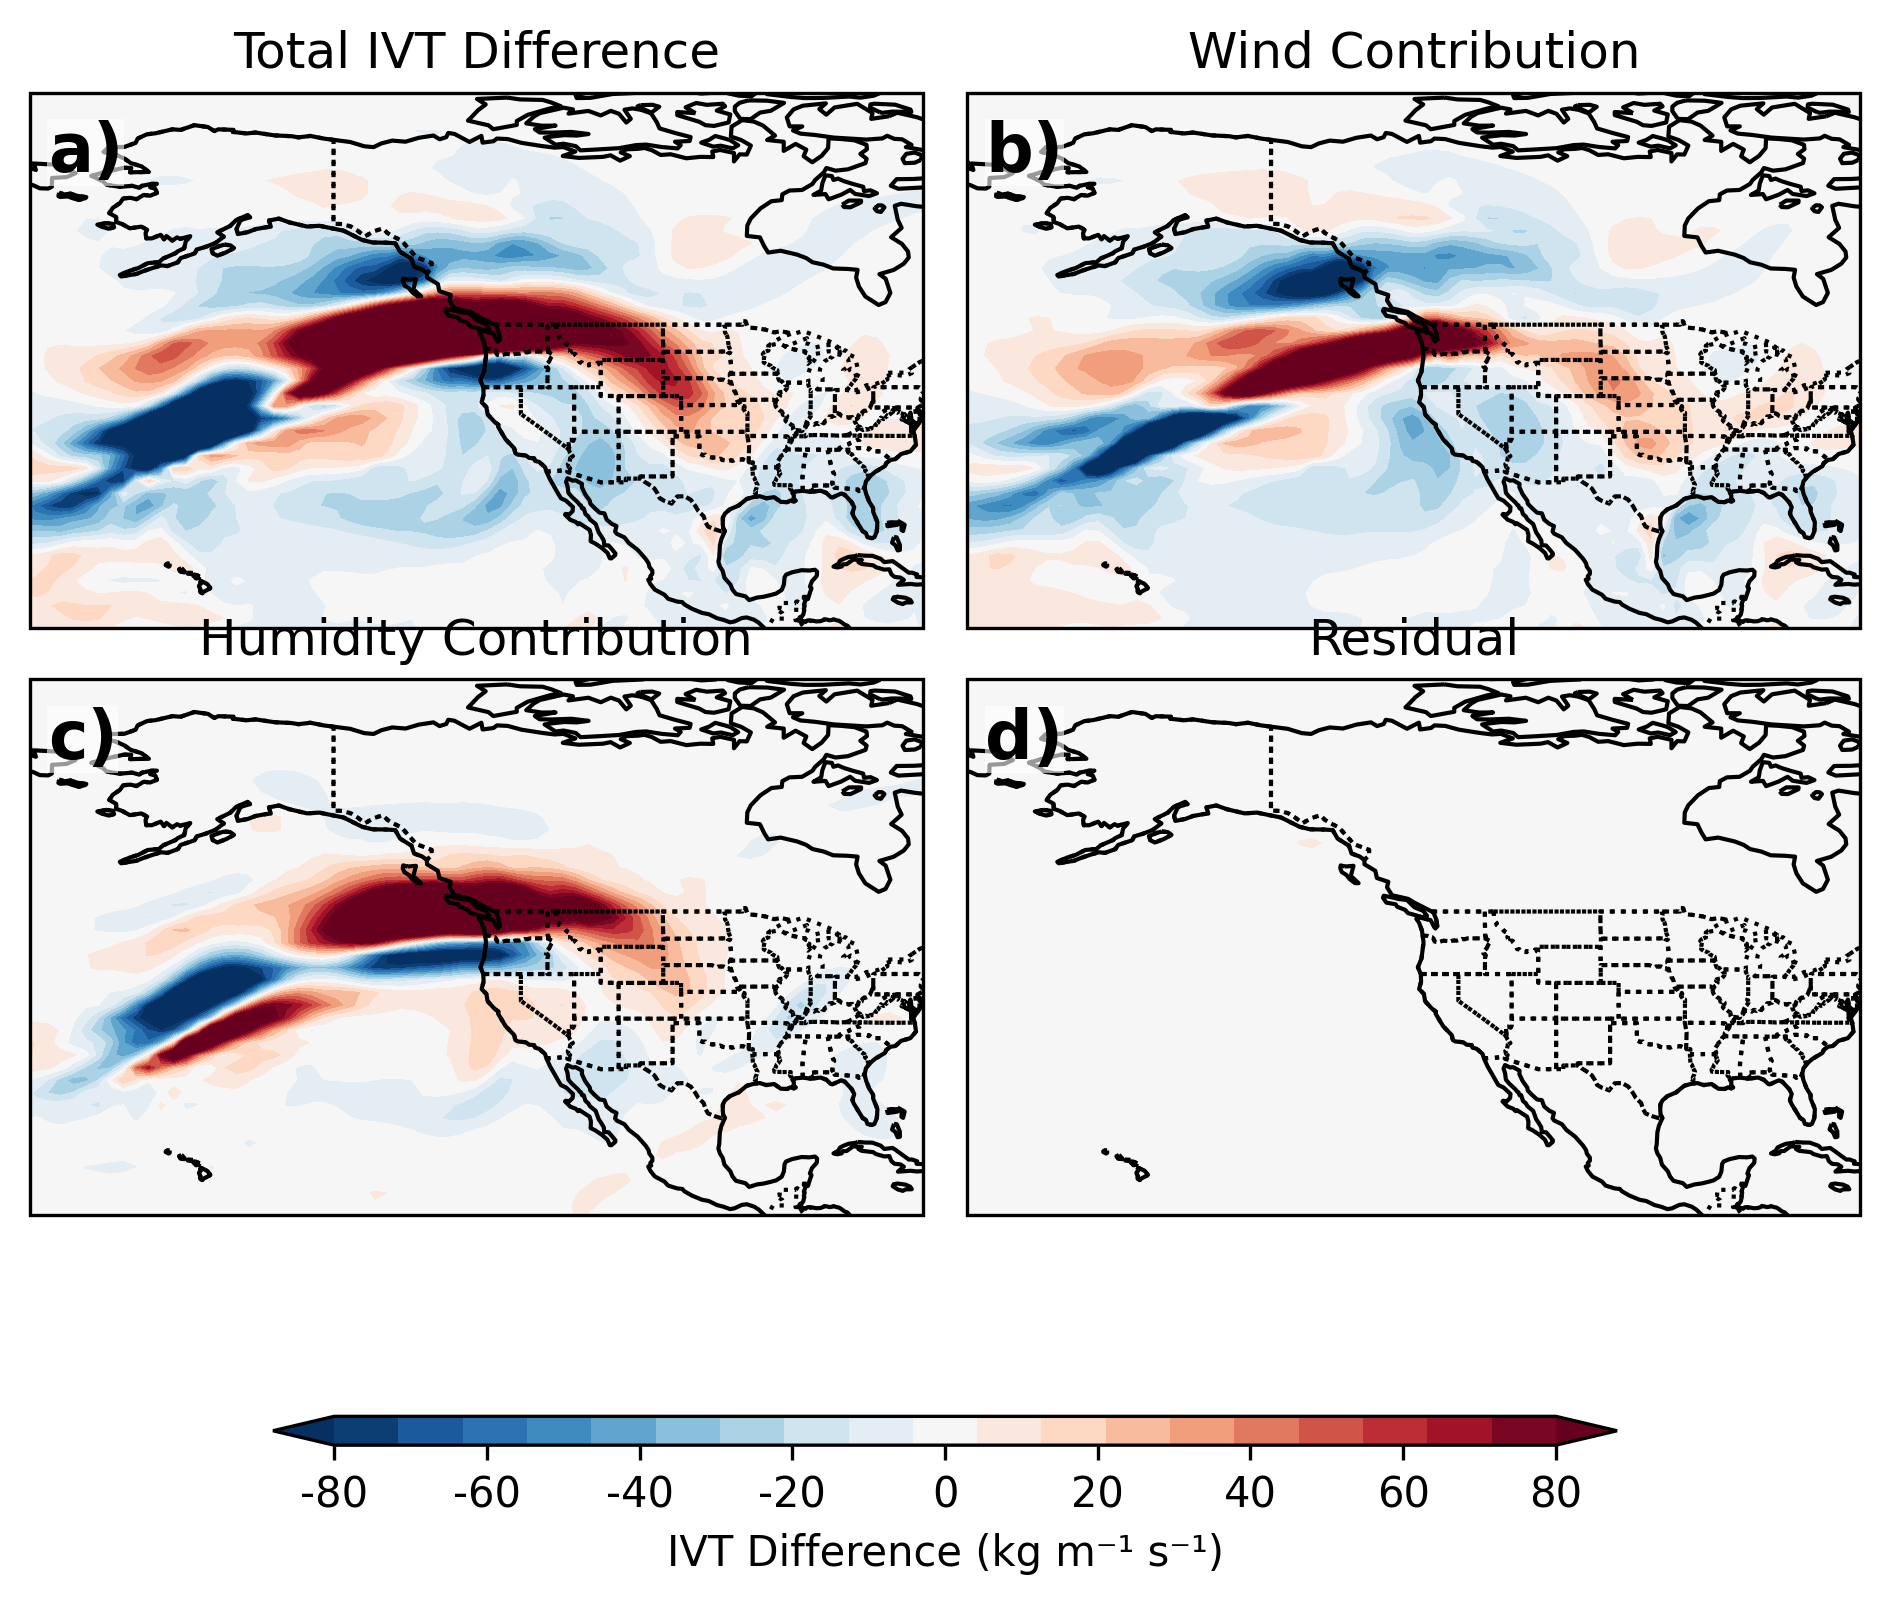

GLOBAL DECOMPOSITION STATISTICS:
Global mean IVT difference: -0.162 kg m⁻¹ s⁻¹
Global mean wind contribution: -0.459 kg m⁻¹ s⁻¹
Global mean humidity contribution: 0.296 kg m⁻¹ s⁻¹
Global mean residual: 0.000 kg m⁻¹ s⁻¹


In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpy as np
from matplotlib.colors import LinearSegmentedColormap


# 1. TIME SERIES DECOMPOSITION OVER TARGET DOMAIN
def compute_ivt_decomposition_timeseries(q_control, u_control, v_control,
                                       q_optimized, u_optimized, v_optimized,
                                       pressure_levels, mask, epsilon=1e-10):
    """Compute IVT decomposition time series over target domain"""
    # Convert to JAX arrays
    q_control_jax = jnp.array(q_control.values)
    u_control_jax = jnp.array(u_control.values)
    v_control_jax = jnp.array(v_control.values)
    q_optimized_jax = jnp.array(q_optimized.values)
    u_optimized_jax = jnp.array(u_optimized.values)
    v_optimized_jax = jnp.array(v_optimized.values)

    # Pressure levels and dp calculation
    pressure_levels_pa = pressure_levels * 100.0
    p = pressure_levels_pa

    dp = jnp.zeros_like(p)
    dp = dp.at[1:-1].set((p[:-2] - p[2:]) / 2.0)
    dp = dp.at[0].set(p[0] - p[1])
    dp = dp.at[-1].set(p[-2] - p[-1])
    dp = dp[None, :, None, None]

    g = 9.80665

    def compute_ivt_components(q, u, v):
        Q_u = jnp.sum(q * u * dp, axis=1) / g
        Q_v = jnp.sum(q * v * dp, axis=1) / g
        IVT = jnp.sqrt(Q_u**2 + Q_v**2)
        return Q_u, Q_v, IVT

    # Compute IVT components
    Q_u_control, Q_v_control, IVT_control = compute_ivt_components(q_control_jax, u_control_jax, v_control_jax)
    Q_u_opt, Q_v_opt, IVT_optimized = compute_ivt_components(q_optimized_jax, u_optimized_jax, v_optimized_jax)

    # Apply mask
    lon_indices, lat_indices = mask
    Q_u_control_masked = Q_u_control[:, lat_indices[0]:lat_indices[-1], lon_indices[0]:lon_indices[-1]]
    Q_v_control_masked = Q_v_control[:, lat_indices[0]:lat_indices[-1], lon_indices[0]:lon_indices[-1]]
    IVT_control_masked = IVT_control[:, lat_indices[0]:lat_indices[-1], lon_indices[0]:lon_indices[-1]]
    Q_u_opt_masked = Q_u_opt[:, lat_indices[0]:lat_indices[-1], lon_indices[0]:lon_indices[-1]]
    Q_v_opt_masked = Q_v_opt[:, lat_indices[0]:lat_indices[-1], lon_indices[0]:lon_indices[-1]]
    IVT_optimized_masked = IVT_optimized[:, lat_indices[0]:lat_indices[-1], lon_indices[0]:lon_indices[-1]]

    # Decomposition calculations
    delta_u = u_optimized_jax - u_control_jax
    delta_v = v_optimized_jax - v_control_jax
    delta_q = q_optimized_jax - q_control_jax

    u_mean = (u_optimized_jax + u_control_jax) / 2
    v_mean = (v_optimized_jax + v_control_jax) / 2
    q_mean = (q_optimized_jax + q_control_jax) / 2

    delta_Q_u_wind = jnp.sum(q_mean * delta_u * dp, axis=1) / g
    delta_Q_v_wind = jnp.sum(q_mean * delta_v * dp, axis=1) / g
    delta_Q_u_humidity = jnp.sum(u_mean * delta_q * dp, axis=1) / g
    delta_Q_v_humidity = jnp.sum(v_mean * delta_q * dp, axis=1) / g

    # Apply mask to decomposition components
    delta_Q_u_wind_masked = delta_Q_u_wind[:, lat_indices[0]:lat_indices[-1], lon_indices[0]:lon_indices[-1]]
    delta_Q_v_wind_masked = delta_Q_v_wind[:, lat_indices[0]:lat_indices[-1], lon_indices[0]:lon_indices[-1]]
    delta_Q_u_humidity_masked = delta_Q_u_humidity[:, lat_indices[0]:lat_indices[-1], lon_indices[0]:lon_indices[-1]]
    delta_Q_v_humidity_masked = delta_Q_v_humidity[:, lat_indices[0]:lat_indices[-1], lon_indices[0]:lon_indices[-1]]

    # Mean-state decomposition
    Q_u_mean_masked = (Q_u_control_masked + Q_u_opt_masked) / 2
    Q_v_mean_masked = (Q_v_control_masked + Q_v_opt_masked) / 2
    IVT_mean_masked = jnp.sqrt(Q_u_mean_masked**2 + Q_v_mean_masked**2)

    IVT_mean_safe = jnp.maximum(IVT_mean_masked, epsilon)
    weights_u = Q_u_mean_masked / IVT_mean_safe
    weights_v = Q_v_mean_masked / IVT_mean_safe

    IVT_diff_wind = weights_u * delta_Q_u_wind_masked + weights_v * delta_Q_v_wind_masked
    IVT_diff_humidity = weights_u * delta_Q_u_humidity_masked + weights_v * delta_Q_v_humidity_masked

    # Total differences
    IVT_diff_actual = IVT_optimized_masked - IVT_control_masked
    residual = IVT_diff_actual - (IVT_diff_wind + IVT_diff_humidity)

    # Spatial averages for time series
    time_series = {
        'IVT_control': jnp.mean(IVT_control_masked, axis=(-2, -1)),
        'IVT_optimized': jnp.mean(IVT_optimized_masked, axis=(-2, -1)),
        'IVT_diff_actual': jnp.mean(IVT_diff_actual, axis=(-2, -1)),
        'IVT_diff_wind': jnp.mean(IVT_diff_wind, axis=(-2, -1)),
        'IVT_diff_humidity': jnp.mean(IVT_diff_humidity, axis=(-2, -1)),
        'residual': jnp.mean(residual, axis=(-2, -1))
    }

    return time_series

# Compute time series decomposition
ts_decomposition = compute_ivt_decomposition_timeseries(
    predictions_ds_ori.specific_humidity,
    predictions_ds_ori.u_component_of_wind,
    predictions_ds_ori.v_component_of_wind,
    predictions_ds.specific_humidity,
    predictions_ds.u_component_of_wind,
    predictions_ds.v_component_of_wind,
    pressure_levels,
    mask
)

# --- FIGURE 1: TIME SERIES PLOT ---
fig_ts = plt.figure(figsize=(12, 8))

# --- Subplot 1 ---
ax1 = plt.subplot(2, 1, 1)
shaded_start_index = 24 + 6
shaded_end_index = 24 * 2 + 6
shaded_start_time = prediction_times[shaded_start_index]
shaded_end_time = prediction_times[shaded_end_index]
plt.axvspan(shaded_start_time, shaded_end_time, color='gray', alpha=0.3, label='Optimization Target')
plt.plot(prediction_times, ts_decomposition['IVT_optimized'], label='Optimized', linewidth=2)
plt.plot(prediction_times, ts_decomposition['IVT_control'], label='Control', linewidth=2)
plt.ylabel("Mean IVT (kg m⁻¹ s⁻¹)")
plt.legend()
plt.grid(True)
ax1.text(0.02, 0.95, 'a)', transform=ax1.transAxes,
         fontsize=16, fontweight='bold', va='top', ha='left',
         bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', pad=0.1))

# --- Subplot 2 ---
ax2 = plt.subplot(2, 1, 2)
shaded_start_index = 24 + 6
shaded_end_index = 24 * 2 + 6
shaded_start_time = prediction_times[shaded_start_index]
shaded_end_time = prediction_times[shaded_end_index]
plt.axvspan(shaded_start_time, shaded_end_time, color='gray', alpha=0.3)
plt.plot(prediction_times, ts_decomposition['IVT_diff_wind'], label='Wind Contribution', linewidth=2)
plt.plot(prediction_times, ts_decomposition['IVT_diff_humidity'], label='Humidity Contribution', linewidth=2)
plt.plot(prediction_times, ts_decomposition['residual'], label='Residual', linewidth=1, linestyle='--')
plt.plot(prediction_times, ts_decomposition['IVT_diff_actual'], label='Total Difference', color='black', linewidth=2, linestyle=':')
plt.xlabel("Time")
plt.ylabel("IVT Difference (kg m⁻¹ s⁻¹)")
plt.legend()
plt.grid(True)
# Add panel label
ax2.text(0.02, 0.95, 'b)', transform=ax2.transAxes,
         fontsize=16, fontweight='bold', va='top', ha='left',
         bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', pad=0.1))

plt.tight_layout()
plt.show()

# Print summary
total_avg = np.mean(ts_decomposition['IVT_diff_actual'])
wind_avg = np.mean(ts_decomposition['IVT_diff_wind'])
humidity_avg = np.mean(ts_decomposition['IVT_diff_humidity'])
residual_avg = np.mean(ts_decomposition['residual'])

print("TIME-AVERAGED DECOMPOSITION:")
print(f"Total IVT difference: {total_avg:.3f} kg m⁻¹ s⁻¹")
print(f"Wind contribution: {wind_avg:.3f} kg m⁻¹ s⁻¹ ({(wind_avg/total_avg)*100:.1f}%)")
print(f"Humidity contribution: {humidity_avg:.3f} kg m⁻¹ s⁻¹ ({(humidity_avg/total_avg)*100:.1f}%)")
print(f"Residual: {residual_avg:.3f} kg m⁻¹ s⁻¹ ({(residual_avg/total_avg)*100:.1f}%)")

# 2. GLOBAL MAPS WITH CARTOPY
def compute_global_decomposition_maps(q_control, u_control, v_control,
                                    q_optimized, u_optimized, v_optimized,
                                    pressure_levels, time_slice=slice(24 + 6, 24*2 + 6), epsilon=1e-10):
    """Compute global decomposition maps"""
    # Convert to JAX arrays
    q_control_jax = jnp.array(q_control.values)
    u_control_jax = jnp.array(u_control.values)
    v_control_jax = jnp.array(v_control.values)
    q_optimized_jax = jnp.array(q_optimized.values)
    u_optimized_jax = jnp.array(u_optimized.values)
    v_optimized_jax = jnp.array(v_optimized.values)

    # Pressure levels and dp calculation
    pressure_levels_pa = pressure_levels * 100.0
    p = pressure_levels_pa

    dp = jnp.zeros_like(p)
    dp = dp.at[1:-1].set((p[:-2] - p[2:]) / 2.0)
    dp = dp.at[0].set(p[0] - p[1])
    dp = dp.at[-1].set(p[-2] - p[-1])
    dp = dp[None, :, None, None]

    g = 9.80665

    def compute_ivt_components(q, u, v):
        Q_u = jnp.sum(q * u * dp, axis=1) / g
        Q_v = jnp.sum(q * v * dp, axis=1) / g
        IVT = jnp.sqrt(Q_u**2 + Q_v**2)
        return Q_u, Q_v, IVT

    # Compute IVT components
    Q_u_control, Q_v_control, IVT_control = compute_ivt_components(q_control_jax, u_control_jax, v_control_jax)
    Q_u_opt, Q_v_opt, IVT_optimized = compute_ivt_components(q_optimized_jax, u_optimized_jax, v_optimized_jax)

    # Decomposition calculations
    delta_u = u_optimized_jax - u_control_jax
    delta_v = v_optimized_jax - v_control_jax
    delta_q = q_optimized_jax - q_control_jax

    u_mean = (u_optimized_jax + u_control_jax) / 2
    v_mean = (v_optimized_jax + v_control_jax) / 2
    q_mean = (q_optimized_jax + q_control_jax) / 2

    delta_Q_u_wind = jnp.sum(q_mean * delta_u * dp, axis=1) / g
    delta_Q_v_wind = jnp.sum(q_mean * delta_v * dp, axis=1) / g
    delta_Q_u_humidity = jnp.sum(u_mean * delta_q * dp, axis=1) / g
    delta_Q_v_humidity = jnp.sum(v_mean * delta_q * dp, axis=1) / g

    # Mean-state decomposition
    Q_u_mean = (Q_u_control + Q_u_opt) / 2
    Q_v_mean = (Q_v_control + Q_v_opt) / 2
    IVT_mean = jnp.sqrt(Q_u_mean**2 + Q_v_mean**2)

    IVT_mean_safe = jnp.maximum(IVT_mean, epsilon)
    weights_u = Q_u_mean / IVT_mean_safe
    weights_v = Q_v_mean / IVT_mean_safe

    IVT_diff_wind = weights_u * delta_Q_u_wind + weights_v * delta_Q_v_wind
    IVT_diff_humidity = weights_u * delta_Q_u_humidity + weights_v * delta_Q_v_humidity

    # Total differences
    IVT_diff_actual = IVT_optimized - IVT_control
    residual = IVT_diff_actual - (IVT_diff_wind + IVT_diff_humidity)

    # Time average
    maps = {
        'IVT_control': jnp.mean(IVT_control[time_slice], axis=0),
        'IVT_optimized': jnp.mean(IVT_optimized[time_slice], axis=0),
        'IVT_diff_actual': jnp.mean(IVT_diff_actual[time_slice], axis=0),
        'IVT_diff_wind': jnp.mean(IVT_diff_wind[time_slice], axis=0),
        'IVT_diff_humidity': jnp.mean(IVT_diff_humidity[time_slice], axis=0),
        'residual': jnp.mean(residual[time_slice], axis=0)
    }

    return maps

# Compute global maps
global_maps = compute_global_decomposition_maps(
    predictions_ds_ori.specific_humidity,
    predictions_ds_ori.u_component_of_wind,
    predictions_ds_ori.v_component_of_wind,
    predictions_ds.specific_humidity,
    predictions_ds.u_component_of_wind,
    predictions_ds.v_component_of_wind,
    pressure_levels
)

# Get coordinates
lats = predictions_ds.latitude.values
lons = predictions_ds.longitude.values

# Fix dimension ordering for plotting
if global_maps['IVT_control'].shape[0] == len(lats) and global_maps['IVT_control'].shape[1] == len(lons):
    plot_data = global_maps
else:
    plot_data = {key: value.T for key, value in global_maps.items()}

# Define North America extent for Cartopy
# [lon_min, lon_max, lat_min, lat_max]
na_extent = [-175, -75, 15, 75]


# --- FIGURE 2: IVT MAPS (CONTROL & OPTIMIZED) ---
print("Generating Figure 2: Control and Optimized IVT over North America...")

# Define the custom IVT colormap
ivt_colors = ["lightgray", "#005C4F", "#00A541", "#E3D100",
              "#9E7D00", "#FE0101", "#960056"]
ivt_cmap = LinearSegmentedColormap.from_list("ivt", ivt_colors, N=256)

fig1 = plt.figure(dpi=300)
projection = ccrs.PlateCarree()

plots_config_1 = [
    (plot_data['IVT_control'], ivt_cmap, None, 'Control IVT'),
    (plot_data['IVT_optimized'], ivt_cmap, None, 'Optimized IVT'),
]

# Use the hardcoded color bar range
vmin1, vmax1 = 0, 1200

plot_handles1 = []
panel_labels_1 = ['a)', 'b)'] # Labels for Figure 2

for i, (data, cmap, vscale, title) in enumerate(plots_config_1):
    ax = fig1.add_subplot(1, 2, i + 1, projection=projection)
    ax.set_extent(na_extent, crs=projection)

    im = ax.contourf(lons, lats, data, levels=np.linspace(vmin1, vmax1, 10), cmap=cmap,
                     vmin=vmin1, vmax=vmax1, transform=projection, extend='both')
    plot_handles1.append(im)

    ax.set_title(title, fontsize=12)
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.STATES, linestyle=':')

    ax.text(0.02, 0.95, panel_labels_1[i], transform=ax.transAxes,
            fontsize=16, fontweight='bold', va='top', ha='left',
            bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', pad=0.1))

fig1.tight_layout()


cbar_ax1 = fig1.add_axes([0.15, 0.1, 0.7, 0.03])
cbar_ticks1 = np.arange(0, 1201, 100)

fig1.colorbar(plot_handles1[0], cax=cbar_ax1, orientation='horizontal',
              label='IVT (kg m⁻¹ s⁻¹)', ticks=cbar_ticks1, format='%d')

plt.show()


# --- FIGURE 3: DECOMPOSITION MAPS (DIFFERENCES) ---
print("Generating Figure 3: IVT Difference Decomposition over North America...")
fig2 = plt.figure(dpi=300)
projection = ccrs.PlateCarree()

plots_config_2 = [
    (plot_data['IVT_diff_actual'], 'RdBu_r', 'sym', 'Total IVT Difference'),
    (plot_data['IVT_diff_wind'], 'RdBu_r', 'sym', 'Wind Contribution'),
    (plot_data['IVT_diff_humidity'], 'RdBu_r', 'sym', 'Humidity Contribution'),
    (plot_data['residual'], 'RdBu_r', 'sym', 'Residual')
]

vmax2 = 80
vmin2 = -80

plot_handles2 = []
panel_labels_2 = ['a)', 'b)', 'c)', 'd)']

for i, (data, cmap, vscale, title) in enumerate(plots_config_2):
    ax = fig2.add_subplot(2, 2, i + 1, projection=projection)
    ax.set_extent(na_extent, crs=projection)

    im = ax.contourf(lons, lats, data, levels=np.linspace(vmin2, vmax2, 20), cmap=cmap,
                     vmin=vmin2, vmax=vmax2, transform=projection, extend='both')
    plot_handles2.append(im)

    ax.set_title(title, fontsize=12)
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.STATES, linestyle=':')

    ax.text(0.02, 0.95, panel_labels_2[i], transform=ax.transAxes,
            fontsize=16, fontweight='bold', va='top', ha='left',
            bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', pad=0.1))

fig2.tight_layout()

fig2.subplots_adjust(bottom=0.15)


cbar_ax2 = fig2.add_axes([0.15, 0.005, 0.7, 0.02])

cbar_ticks2 = np.arange(-80, 81, 20)

fig2.colorbar(plot_handles2[0], cax=cbar_ax2, orientation='horizontal',
              label='IVT Difference (kg m⁻¹ s⁻¹)', ticks=cbar_ticks2, format='%d')

plt.show()


# Print global statistics
print("GLOBAL DECOMPOSITION STATISTICS:")
print(f"Global mean IVT difference: {np.mean(plot_data['IVT_diff_actual']):.3f} kg m⁻¹ s⁻¹")
print(f"Global mean wind contribution: {np.mean(plot_data['IVT_diff_wind']):.3f} kg m⁻¹ s⁻¹")
print(f"Global mean humidity contribution: {np.mean(plot_data['IVT_diff_humidity']):.3f} kg m⁻¹ s⁻¹")
print(f"Global mean residual: {np.mean(plot_data['residual']):.3f} kg m⁻¹ s⁻¹")

Generating Figure 4: Side-by-side IVT, 850 hPa Wind, and Geopotential...
Successfully loaded all data for comparison plot.


/tmp/ipython-input-2414686083.py:209: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.1, 1, 1])
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


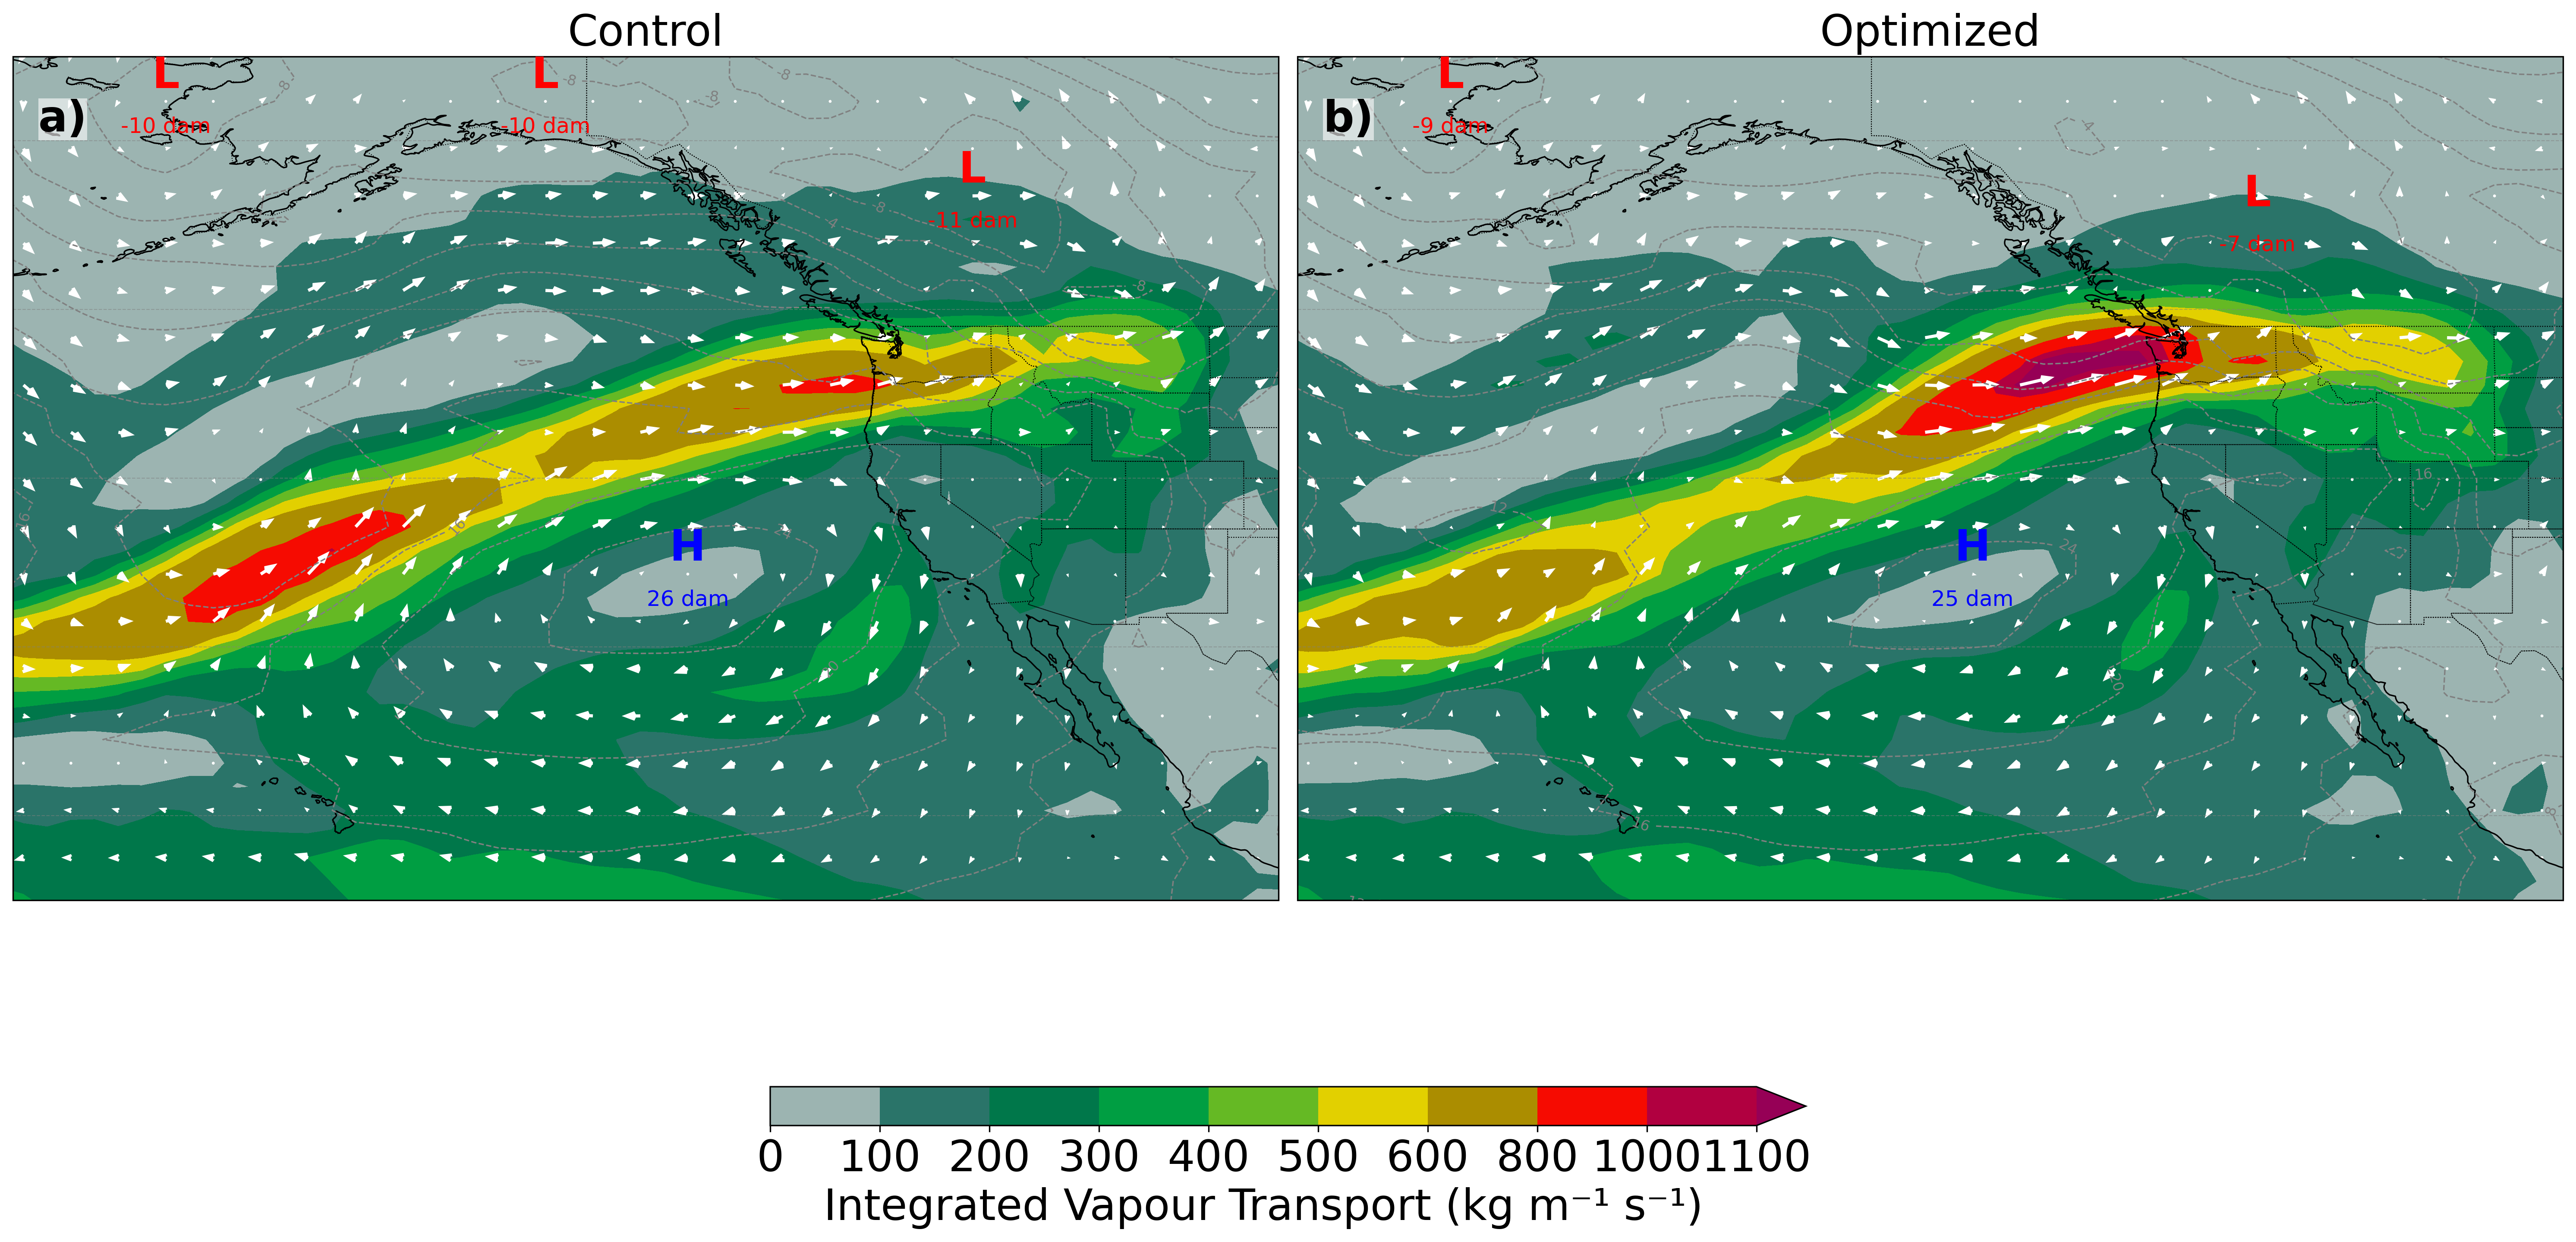

In [ ]:
import scipy.ndimage as ndimage
import matplotlib.ticker as mticker
try:
    from cartopy.mpl.ticker import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
except ImportError:
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpy as np
from matplotlib.colors import LinearSegmentedColormap


# ---
# --- FIGURE 4: SIDE-BY-SIDE IVT, VECTORS, & GEOPOTENTIAL (NEW AXIS FIX) ---
# ---
print("Generating Figure 4: Side-by-side IVT, 850 hPa Wind, and Geopotential...")

map_time_index = 45
time_slice_for_map = slice(map_time_index, map_time_index+1)

single_time_maps = compute_global_decomposition_maps(
    predictions_ds_ori.specific_humidity,
    predictions_ds_ori.u_component_of_wind,
    predictions_ds_ori.v_component_of_wind,
    predictions_ds.specific_humidity,
    predictions_ds.u_component_of_wind,
    predictions_ds.v_component_of_wind,
    pressure_levels,
    time_slice=time_slice_for_map
)

# --- 1. PREPARE ALL DATA FOR BOTH PLOTS ---

ivt_control = single_time_maps['IVT_control'].squeeze()
ivt_optimized = single_time_maps['IVT_optimized'].squeeze()
if ivt_control.shape[0] == len(lons):
    ivt_control = ivt_control.T
    ivt_optimized = ivt_optimized.T

try:
    # --- Control Data (ori) ---
    u_wind_850_ori = predictions_ds_ori.u_component_of_wind.isel(time=map_time_index).sel(level=850, method='nearest').values
    v_wind_850_ori = predictions_ds_ori.v_component_of_wind.isel(time=map_time_index).sel(level=850, method='nearest').values
    gph_1000_ori = predictions_ds_ori.geopotential.isel(time=map_time_index).sel(level=1000, method='nearest').values

    # --- Optimized Data (opt) ---
    u_wind_850_opt = predictions_ds.u_component_of_wind.isel(time=map_time_index).sel(level=850, method='nearest').values
    v_wind_850_opt = predictions_ds.v_component_of_wind.isel(time=map_time_index).sel(level=850, method='nearest').values
    gph_1000_opt = predictions_ds.geopotential.isel(time=map_time_index).sel(level=1000, method='nearest').values

    # --- Transpose all if needed ---
    if u_wind_850_ori.shape[0] == len(lons):
        # Transpose Control
        u_wind_850_ori = u_wind_850_ori.T
        v_wind_850_ori = v_wind_850_ori.T
        gph_1000_ori = gph_1000_ori.T
        # Transpose Optimized
        u_wind_850_opt = u_wind_850_opt.T
        v_wind_850_opt = v_wind_850_opt.T
        gph_1000_opt = gph_1000_opt.T

    # --- Convert GPH to dam ---
    g = 9.80665
    gph_dam_ori = gph_1000_ori / g / 10.0
    gph_dam_opt = gph_1000_opt / g / 10.0

    print("Successfully loaded all data for comparison plot.")
    data_loaded_flag = True

except (AttributeError, KeyError, NameError, TypeError) as e:
    print(f"WARNING (Fig 4): Could not load all data for comparison. Error: {e}")
    data_loaded_flag = False
    u_wind_850_ori, v_wind_850_ori, gph_dam_ori = [np.zeros((len(lats), len(lons)))] * 3
    u_wind_850_opt, v_wind_850_opt, gph_dam_opt = [np.zeros((len(lats), len(lons)))] * 3

# --- 2. CREATE FIGURE ---
fig4 = plt.figure(figsize=(20, 10), dpi=300)
projection = ccrs.PlateCarree()

custom_extent = [185, 260, 15, 65]

# --- Plotting Config ---
# IVT Colormap & Levels
ivt_colors = ["lightgray", "#005C4F", "#00A541", "#E3D100",
              "#9E7D00", "#FE0101", "#960056"]
ivt_cmap = LinearSegmentedColormap.from_list("ivt", ivt_colors, N=256)
ivt_levels = np.array([0, 100, 200, 300, 400, 500, 600, 800, 1000, 1100])
cbar_ticks = [0, 100, 200, 300, 400, 500, 600, 800, 1000, 1100]

# Geopotential Levels (common)
if data_loaded_flag:
    gph_min = min(np.nanmin(gph_dam_ori), np.nanmin(gph_dam_opt))
    gph_max = max(np.nanmax(gph_dam_ori), np.nanmax(gph_dam_opt))
    contour_levels_dam = np.arange(int(gph_min) - 4, int(gph_max) + 4, 4)
else:
    contour_levels_dam = np.arange(0, 40, 4)

# Quiver settings
skip = 2
quiver_scale = 1000
quiver_width = 0.0025
quiver_hw = 3
quiver_hl = 4

# H/L filter size
neighborhood_size = 15

# --- Data list for looping ---
plot_config = [
    ('Control', ivt_control, u_wind_850_ori, v_wind_850_ori, gph_dam_ori),
    ('Optimized', ivt_optimized, u_wind_850_opt, v_wind_850_opt, gph_dam_opt)
]
plot_handles = []
panel_labels = ['a)', 'b)']

# --- 3. LOOP AND PLOT ---
for i, (title, ivt_data, u_data, v_data, gph_data) in enumerate(plot_config):
    ax4 = fig4.add_subplot(1, 2, i + 1, projection=projection)
    ax4.set_extent(custom_extent, crs=ccrs.PlateCarree())

    # --- Plot IVT (Contourf) ---
    cf = ax4.contourf(lons, lats, ivt_data, levels=ivt_levels, cmap=ivt_cmap,
                     transform=ccrs.PlateCarree(), extend='max')
    if i == 0:
        plot_handles.append(cf) # For common colorbar

    # --- Plot 850 hPa Wind (Quiver) ---
    ax4.quiver(lons[::skip], lats[::skip], u_data[::skip, ::skip], v_data[::skip, ::skip],
              color='white', scale=quiver_scale, width=quiver_width,
              headwidth=quiver_hw, headlength=quiver_hl, transform=ccrs.PlateCarree())

    # --- Plot Map Features ---
    ax4.coastlines(resolution='50m', linewidth=0.8)
    ax4.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='black', linewidth=0.5)
    ax4.add_feature(cfeature.STATES, linestyle=':', edgecolor='black', linewidth=0.5)

    # --- Plot Geopotential (Contours) ---
    if data_loaded_flag:
        cs_geopotential = ax4.contour(lons, lats, gph_data, levels=contour_levels_dam,
                                     colors='gray', linestyles='dashed', linewidths=0.8,
                                     transform=ccrs.PlateCarree())
        ax4.clabel(cs_geopotential, inline=True, fontsize=8, fmt='%d')

        # --- Find and plot H/L labels ---
        data_min = ndimage.minimum_filter(gph_data, size=neighborhood_size)
        data_max = ndimage.maximum_filter(gph_data, size=neighborhood_size)

        # Lows
        minima_idx = np.where(gph_data == data_min)
        for j in range(len(minima_idx[0])):
            lat_idx, lon_idx = minima_idx[0][j], minima_idx[1][j]
            lon_val, lat_val = lons[lon_idx], lats[lat_idx]
            if (custom_extent[0] < lon_val < custom_extent[1]) and (custom_extent[2] < lat_val < custom_extent[3]):
                gph_val = int(np.round(gph_data[lat_idx, lon_idx]))
                ax4.text(lon_val, lat_val + 1.5, 'L', color='red', fontsize=24, fontweight='bold', ha='center', va='center', transform=ccrs.PlateCarree())
                ax4.text(lon_val, lat_val - 1.5, f"{gph_val} dam", color='red', fontsize=12, ha='center', va='center', transform=ccrs.PlateCarree())

        # Highs
        maxima_idx = np.where(gph_data == data_max)
        for j in range(len(maxima_idx[0])):
            lat_idx, lon_idx = maxima_idx[0][j], maxima_idx[1][j]
            lon_val, lat_val = lons[lon_idx], lats[lat_idx]
            if (custom_extent[0] < lon_val < custom_extent[1]) and (custom_extent[2] < lat_val < custom_extent[3]):
                gph_val = int(np.round(gph_data[lat_idx, lon_idx]))
                ax4.text(lon_val, lat_val + 1.5, 'H', color='blue', fontsize=24, fontweight='bold', ha='center', va='center', transform=ccrs.PlateCarree())
                ax4.text(lon_val, lat_val - 1.5, f"{gph_val} dam", color='blue', fontsize=12, ha='center', va='center', transform=ccrs.PlateCarree())

    gl = ax4.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                      linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

    gl.xlabels_bottom = True
    gl.ylabels_left = (i == 0)

    gl.xlines = True
    gl.ylines = True
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 18, 'color': 'black'}
    gl.ylabel_style = {'size': 18, 'color': 'black'}
    gl.xlocator = mticker.FixedLocator(np.arange(190, 260, 10))
    gl.ylocator = mticker.FixedLocator(np.arange(20, 70, 10))

    ax4.text(0.02, 0.95, panel_labels[i], transform=ax4.transAxes,
            fontsize=24, fontweight='bold', va='top', ha='left',
            bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', pad=0.1))
    ax4.set_title(title, fontsize=24)

# --- 4. COMMON COLORBAR ---
cbar_ax4 = fig4.add_axes([0.3, 0.05, 0.4, 0.03])
cbar = fig4.colorbar(plot_handles[0], cax=cbar_ax4, orientation='horizontal',
                    label='Integrated Vapour Transport (kg m⁻¹ s⁻¹)',
                    ticks=cbar_ticks, format='%d')
cbar.ax.tick_params(labelsize=24)
cbar.set_label('Integrated Vapour Transport (kg m⁻¹ s⁻¹)', fontsize=24)

# Adjust layout to make room for colorbar
plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.show()